# 实验4 CNN&RNN 深度学习

## 1. 时序数据生成

In [1]:
# 导入依赖包
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
import pandas as pd

# 配置 matplotlib显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# # 默认设置double tensor，便于反向传播时保持数值精度
# torch.set_default_dtype(torch.double)

# # 固定随机种子，确保实验结果可重复
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.9.0+cu130


In [2]:
# 定义绘制序列函数
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """
    根据时间轴和对应数据列表绘制序列图像

    参数:
    time: 时间轴数据，一维数组，表示时间点
    series: 时间序列数据，一维数组，与time长度相同，表示对应时刻的值
    format: 线条格式，默认为实线"-"，可选"--"虚线、":"点线等
    start: 绘图的起始索引，默认为0，用于局部绘制
    end: 绘图的结束索引，默认为None（绘制到末尾）
    label: 图例标签，用于区分多条曲线
    """

    # 绘制时间序列曲线
    plt.plot(time[start:end], series[start:end], format, label=label)

    # 设置横纵坐标轴标签
    plt.xlabel("Time")
    plt.ylabel("Value")

    # 如果提供了标签，则显示图例
    if label:
        plt.legend(fontsize=14)

    # 显示网格，便于观察数据点和趋势
    plt.grid(True)


In [3]:
# 趋势模式生成
def trend(time, slope=0):
    """线性趋势：值随时间线性变化。"""
    return slope * time

# 噪声模式生成
def white_noise(time, noise_level=1, seed=None):
    """生成 N(0, 1) 的白噪声，并用 noise_level 控制幅值。"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [4]:
# 季节性模式生成
def seasonal_pattern(season_time):
    """定义一个周期内的季节性模式
    - 前40%的周期使用cos模拟周期波动
    - 后面部分指数衰减模拟下降趋势
    """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),  # 前40%: 余弦波动
                    np.exp(-3 * season_time))          # 后60%: 指数衰减

def seasonality(time, period, amplitude=1, phase=0):
    """
    将季节性模式循环多次生成完整时间序列
    
    参数:
    time: 时间轴数组
    period: 周期长度，如365表示年度周期
    amplitude: 振幅，控制季节性波动的强度
    phase: 相位偏移，控制季节性模式的起始位置，默认为0
    
    返回:
    完整的季节性时间序列
    
    工作原理:
    1. 将时间映射到[0, 1]的周期内：((time + phase) % period) / period
    2. 应用seasonal_pattern函数获取基础模式
    3. 乘以振幅得到最终的季节性序列
    """
    # 计算归一化的季节时间，通过取模实现周期性重复
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

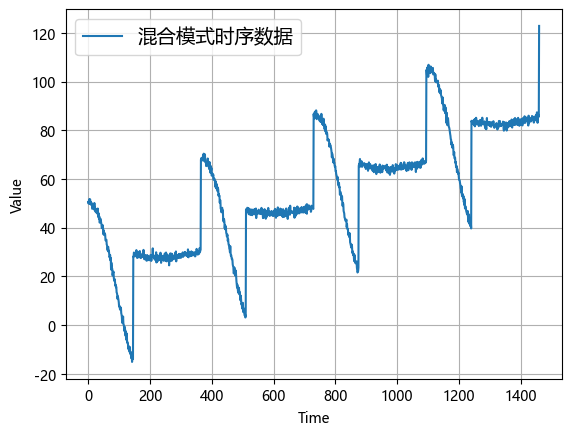

In [5]:
"""
生成实验用的混合模式时序数据
这是最终用于训练和测试的数据集
结合了趋势、季节性和噪声三种成分
"""

# 重新生成时间轴，确保数据一致性
time = np.arange(4 * 365 + 1)  # 1461个时间点

# 设置各成分参数
baseline = 10         # 基线值
slope = 0.05          # 较小的上升趋势，模拟缓慢增长
amplitude = 40        # 季节性振幅
noise_level = 1       # 较小的噪声水平，保持主要模式可见

# 生成混合序列：基线 + 趋势 + 季节性 + 噪声
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + white_noise(time, noise_level, seed=SEED)

# 显示最终生成的时序数据
plot_series(time, series, label='混合模式时序数据')

## 2. 数据处理


In [6]:
# 定义device：优先使用GPU，如果不可用则使用CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
# 划分训练集/测试集函数
def train_test_split(series, split_prop):
    """按比例切分原始长序列。分割训练集和测试集"""
    split_point = int(len(series) * split_prop)
    # 前split_prop比例作为训练集
    train_series = series[:split_point]
    # 剩余部分作为测试集
    test_series = series[split_point:]
    return train_series, test_series

In [8]:
"""
滑窗处理和特征标签划分函数
将长序列转换为多个固定长度的短序列样本
"""

def data_process(train_series, test_series, window_size):
    """
    使用滑动窗口处理时间序列，生成训练和测试样本
    
    参数:
    train_series: 训练集序列，numpy数组
    test_series: 测试集序列，numpy数组
    window_size: 滑窗大小，每个样本包含的时间步数
    
    返回:
    train_features: 训练特征，shape [样本数, window_size-1]
    train_labels: 训练标签，shape [样本数]
    test_features: 测试特征，shape [样本数, window_size-1]
    test_labels: 测试标签，shape [样本数]
    
    处理流程:
    1. 使用unfold进行滑窗：步长为1，每次滑动1个位置
    2. 将训练集样本随机打乱，增强泛化能力
    3. 划分特征和标签：前window_size-1个点作为特征，最后1个点作为标签
    4. 转换为PyTorch tensor格式
    """
    
    # === 训练集滑窗处理 ===
    # 转换为tensor
    train_tesnor = torch.from_numpy(train_series)
    train_window_split = train_tesnor.unfold(0, window_size, 1)
    train_set = train_window_split.numpy()

    # === 测试集滑窗处理 ===
    test_tensor = torch.from_numpy(test_series)
    test_window_split = test_tensor.unfold(0, window_size, 1)
    test_set = test_window_split.numpy()

    # === 训练集短序列随机打乱 ===
    # 打乱训练样本顺序，破坏时间相关性，提高模型泛化能力
    train_temp1 = train_set.tolist()
    random.shuffle(train_temp1)  # 原地打乱
    train_temp2 = np.array(train_temp1)

    # === 划分特征和标签 ===
    # 训练集: 前window_size-1个时间步作为特征（输入）
    train_feature_array = train_temp2[:, :window_size-1]
    # 最后1个时间步作为标签（目标输出）
    train_label_array = train_temp2[:, window_size-1:]
    
    # 测试集: 同样的划分方式，但不打乱顺序（保持时间序列用于可视化）
    test_feature_array = test_set[:, :window_size-1]
    test_label_array = test_set[:, window_size-1:]

    # === 转换为PyTorch tensor ===
    # 使用double类型保持与模型一致，避免类型不匹配
    train_feature_tensor = torch.from_numpy(train_feature_array)
    train_label = torch.from_numpy(train_label_array)
    test_feature_tensor = torch.from_numpy(test_feature_array)
    test_label = torch.from_numpy(test_label_array)
    # === 标签降维 ===
    # 将label从shape [N, 1] 降为 [N]，便于后续损失计算
    train_feature = train_feature_tensor.reshape(train_feature_tensor.shape[0],1,train_feature_tensor.shape[1])
    test_feature = test_feature_tensor.reshape(test_feature_tensor.shape[0],1,test_feature_tensor.shape[1])

    return train_feature, train_label, test_feature, test_label

In [9]:
# 划分 batches 函数
def data_iter(batch_size, features, labels):
    """
    生成指定大小的数据批次，用于小批量梯度下降
    """
    num_examples = len(features)
    indices = list(range(num_examples))

    # 按批次大小遍历所有样本
    for i in range(0, num_examples, batch_size):
        batch_indices = indices[i: min(i + batch_size, num_examples)]
        # 将索引创建到与 features 相同的 device，避免跨设备索引错误
        j = torch.tensor(batch_indices, dtype=torch.long, device=features.device)
        yield features.index_select(0, j), labels.index_select(0, j)


In [10]:
"""
数据预处理主流程
执行训练集/测试集划分和滑窗处理
"""

# 设置训练集划分比例：70%训练集，30%测试集
split_prop = 0.7

# 调用 train_test_split 将完整序列划分为训练集和测试集
# series: 前面已生成的混合模式时序数据（长度1461）
train, test = train_test_split(series, split_prop)

# 设置滑窗大小：每个样本包含6个连续时间点
# 前5个作为特征（输入），最后1个作为标签（输出）
window_size = 6

# 调用 data_process 进行滑窗处理并划分特征与标签
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)

# 打印数据集形状信息，验证处理结果
print(train_feature.shape)  # 训练特征: [训练样本数, 1, 5]
print(train_label.shape)    # 训练标签: [训练样本数, 1]
print(test_feature.shape)   # 测试特征: [测试样本数, 1, 5]
print(test_label.shape)     # 测试标签: [测试样本数, 1]

# === 关键步骤：将所有数据张量移动到与模型相同的 device，并转换为 double ===
# device 在前面已定义，删除冗余的 try/except 检查
# （如果希望保留防护，可使用下面一行作为简短备选）
# device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

train_feature = train_feature.to(device).double()
train_label = train_label.to(device).double()
test_feature = test_feature.to(device).double()
test_label = test_label.to(device).double()

print("数据已移动到 device:", device)

torch.Size([1017, 1, 5])
torch.Size([1017, 1])
torch.Size([434, 1, 5])
torch.Size([434, 1])
数据已移动到 device: cuda


## 3 CNN模拟数据回归

In [11]:
# 构建一维卷积神经网络（平均池化）
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        # 第一层一维卷积模块
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # 第二层一维卷积模块
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        # 全连接层：64 -> 32 -> 1
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, X):
        """
        前向传播：
        X: [batch_size, 1, sequence_length]
        返回: [batch_size, 1]
        """
        out = self.conv1(X)                 # [batch, 32, seq_len]
        out = F.avg_pool1d(out, 2)          # 平均池化，窗口大小2
        out = self.conv2(out)               # [batch, 64, seq_len/2]
        out = F.avg_pool1d(out, 2)          # 再次平均池化
        out = out.squeeze()                 # [batch, 64]
        out = self.fc1(out)                 # [batch, 32]
        out = self.fc2(out)                 # [batch, 1]
        return out

# 实例化模型，确保后续单元使用时 net 已定义
net_avg = ConvModule()
# 将模型参数转换为 double（float64）
net_avg.double()

# 将模型移动到GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_avg.to(device)

ConvModule(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [12]:
# 构建一维卷积神经网络（最大池化）
class ConvModuleMax(nn.Module):
    def __init__(self):
        super(ConvModuleMax, self).__init__()
        # 第一层一维卷积模块
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # 第二层一维卷积模块
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        # 全连接层：64 -> 32 -> 1
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, X):
        """
        前向传播：
        X: [batch_size, 1, sequence_length]
        返回: [batch_size, 1]
        """
        out = self.conv1(X)                 # [batch, 32, seq_len]
        out = F.max_pool1d(out, 2)          # 最大池化，窗口大小2
        out = self.conv2(out)               # [batch, 64, seq_len/2]
        out = F.max_pool1d(out, 2)          # 再次最大池化
        out = out.squeeze()                 # [batch, 64]
        out = self.fc1(out)                 # [batch, 32]
        out = self.fc2(out)                 # [batch, 1]
        return out

# 实例化模型，确保后续单元使用时 net 已定义
net_max = ConvModuleMax()
# 将模型参数转换为 double（float64）
net_max.double()

# 将模型移动到GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_max.to(device)

ConvModuleMax(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
# 定义均方误差损失函数
def squared_loss(y_hat, y):
    """均方误差损失函数"""
    return (y_hat - y.view(y_hat.size())) ** 2 / (y.shape[0])

# 模型参数初始化（平均池化）
for params in net_avg.parameters():
    torch.nn.init.normal_(params, mean=0, std=0.01)
# 模型参数初始化（最大池化）
for params in net_max.parameters():
    torch.nn.init.normal_(params, mean=0, std=0.01)

# 训练超参数设置
lr = 0.0005
num_epochs = 200
batch_size = 128
loss = squared_loss

# 优化器设置（使用 double 参数的 net_avg）
optimizer_avg = torch.optim.Adam(net_avg.parameters(), lr)
# 优化器设置（使用 double 参数的 net_max）
optimizer_max = torch.optim.Adam(net_max.parameters(), lr)


In [14]:
# 训练模型（平均池化）
# 记录每个 epoch 的训练/测试损失
train_loss = []
test_loss = []

# 外循环：训练轮数
for epoch in range(num_epochs):
    train_l, test_l = 0.0, 0.0  # 累计当前 epoch 的训练损失（标量）
    # 内循环：遍历每个 batch
    for X, y in data_iter(batch_size, train_feature, train_label):
        y_hat = net_avg(X)
        l = loss(y_hat, y).sum()  # 计算 batch 总损失（标量）

        # 梯度清零（优先使用 optimizer）
        if optimizer_avg is not None:
            optimizer_avg.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()  # 备用方案：手动清零梯度

        # 反向传播与参数更新
        l.backward()
        optimizer_avg.step()

    # 评估：使用整个训练/测试集计算平均损失
    train_l = loss(net_avg(train_feature), train_label)
    test_l = loss(net_avg(test_feature), test_label)

    train_loss.append(train_l.mean().item())
    test_loss.append(test_l.mean().item())

    # 打印当前 epoch 的训练与测试损失
    print('epoch %d, train loss %f, test loss %f' % (
        epoch + 1, train_l.mean().item(), test_l.mean().item()))

epoch 1, train loss 2.226693, test loss 14.765604
epoch 2, train loss 2.223868, test loss 14.748338
epoch 3, train loss 2.213423, test loss 14.681008
epoch 4, train loss 2.181747, test loss 14.473555
epoch 5, train loss 2.101344, test loss 13.943778
epoch 6, train loss 1.925214, test loss 12.779604
epoch 7, train loss 1.589730, test loss 10.557024
epoch 8, train loss 1.055290, test loss 7.006908
epoch 9, train loss 0.412803, test loss 2.716259
epoch 10, train loss 0.033159, test loss 0.123691
epoch 11, train loss 0.096006, test loss 0.473190
epoch 12, train loss 0.041144, test loss 0.138877
epoch 13, train loss 0.030506, test loss 0.103967
epoch 14, train loss 0.032721, test loss 0.121570
epoch 15, train loss 0.026020, test loss 0.064231
epoch 16, train loss 0.026814, test loss 0.062867
epoch 17, train loss 0.025910, test loss 0.061163
epoch 18, train loss 0.025904, test loss 0.065677
epoch 19, train loss 0.025687, test loss 0.063100
epoch 20, train loss 0.025617, test loss 0.061493
ep

In [15]:
# 训练模型（最大池化）
# 记录每个 epoch 的训练/测试损失
train_loss_max = []
test_loss_max = []

# 外循环：训练轮数
for epoch in range(num_epochs):
    train_l_max, test_l_max = 0.0, 0.0  # 累计当前 epoch 的训练损失（标量）
    # 内循环：遍历每个 batch
    for X, y in data_iter(batch_size, train_feature, train_label):
        y_hat = net_max(X)
        l = loss(y_hat, y).sum()  # 计算 batch 总损失（标量）

        # 梯度清零（优先使用 optimizer）
        if optimizer_max is not None:
            optimizer_max.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()  # 备用方案：手动清零梯度

        # 反向传播与参数更新
        l.backward()
        optimizer_max.step()

    # 评估：使用整个训练/测试集计算平均损失
    train_l_max = loss(net_max(train_feature), train_label)
    test_l_max = loss(net_max(test_feature), test_label)

    train_loss_max.append(train_l_max.mean().item())
    test_loss_max.append(test_l_max.mean().item())
    # 打印当前 epoch 的训练与测试损失
    print('epoch %d, train loss %f, test loss %f' % (
        epoch + 1, train_l_max.mean().item(), test_l_max.mean().item()))

epoch 1, train loss 2.226137, test loss 14.762484
epoch 2, train loss 2.221864, test loss 14.735745
epoch 3, train loss 2.206087, test loss 14.633371
epoch 4, train loss 2.158268, test loss 14.319624
epoch 5, train loss 2.036961, test loss 13.520079
epoch 6, train loss 1.774792, test loss 11.787390
epoch 7, train loss 1.301408, test loss 8.651408
epoch 8, train loss 0.633431, test loss 4.208796
epoch 9, train loss 0.078282, test loss 0.468371
epoch 10, train loss 0.086603, test loss 0.433031
epoch 11, train loss 0.050483, test loss 0.211952
epoch 12, train loss 0.025300, test loss 0.090163
epoch 13, train loss 0.030303, test loss 0.129015
epoch 14, train loss 0.021107, test loss 0.052346
epoch 15, train loss 0.022653, test loss 0.054351
epoch 16, train loss 0.021063, test loss 0.049816
epoch 17, train loss 0.021114, test loss 0.055333
epoch 18, train loss 0.020863, test loss 0.052743
epoch 19, train loss 0.020699, test loss 0.050203
epoch 20, train loss 0.020573, test loss 0.050776
epo

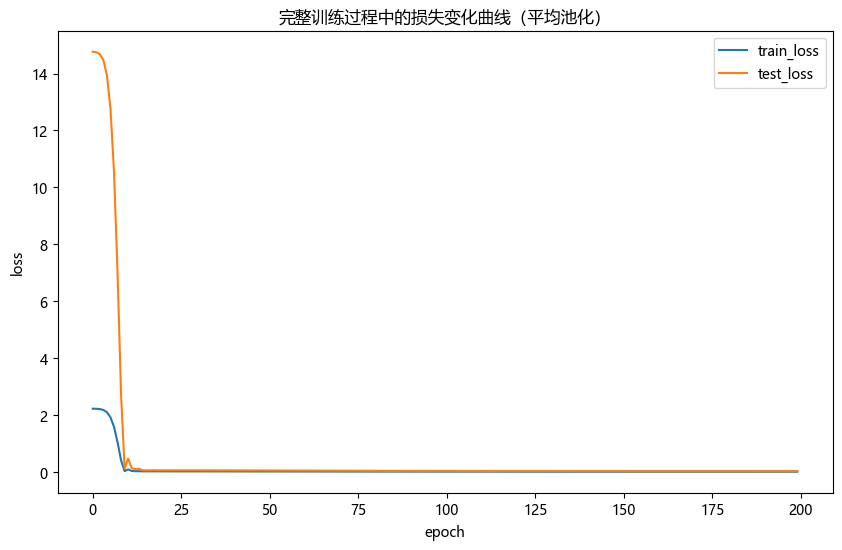

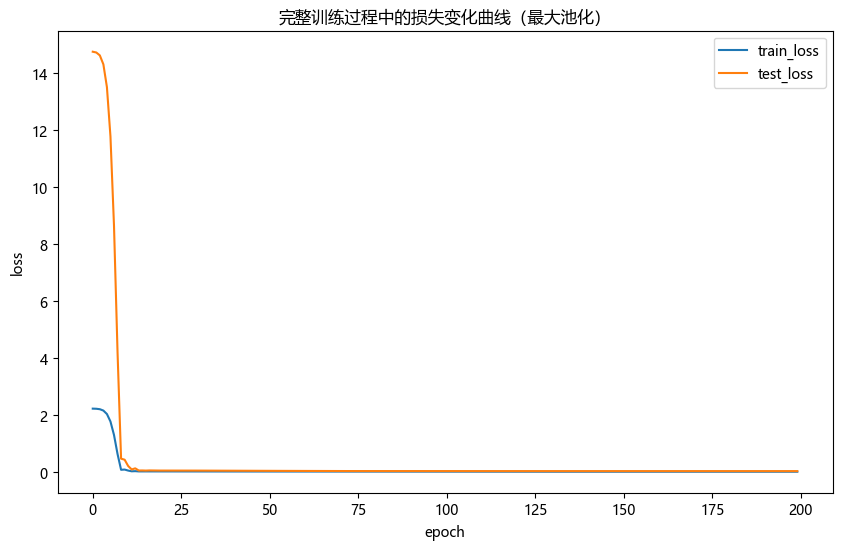

In [16]:
# 绘制完整的loss曲线（平均池化）
# 创建横坐标：从0到num_epochs-1的epoch序列
x = np.arange(num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(x, train_loss, label="train_loss", linewidth=1.5)
plt.plot(x, test_loss, label="test_loss", linewidth=1.5)

# 设置坐标轴标签
plt.xlabel("epoch")    # 横轴标签：训练轮数
plt.ylabel("loss")     # 纵轴标签：损失值

plt.legend()
plt.title("完整训练过程中的损失变化曲线（平均池化）")
plt.show()

# 绘制完整的loss曲线（最大池化）
# 创建横坐标：从0到num_epochs-1的epoch序列
x = np.arange(num_epochs)
plt.figure(figsize=(10, 6))
plt.plot(x, train_loss_max, label="train_loss", linewidth=1.5)
plt.plot(x, test_loss_max, label="test_loss", linewidth=1.5)
# 设置坐标轴标签
plt.xlabel("epoch")    # 横轴标签：训练轮数
plt.ylabel("loss")     # 纵轴标签：损失值

plt.legend()
plt.title("完整训练过程中的损失变化曲线（最大池化）")
plt.show()


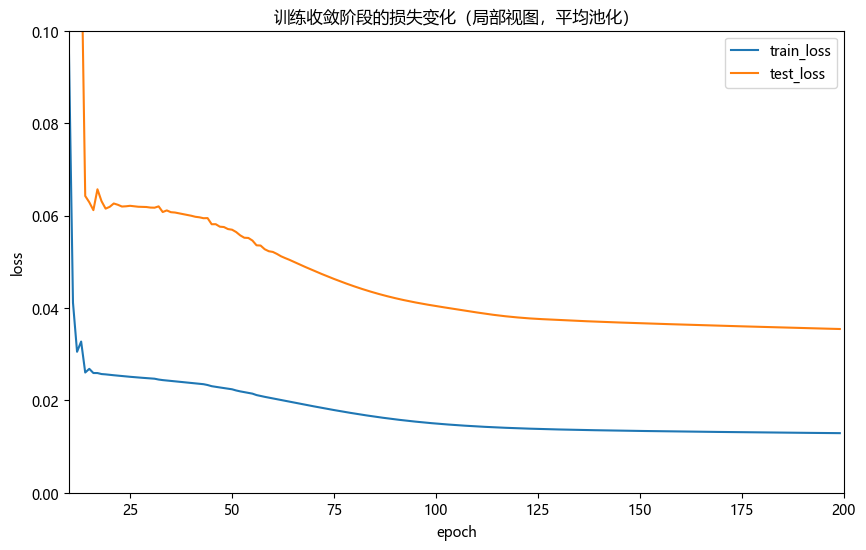

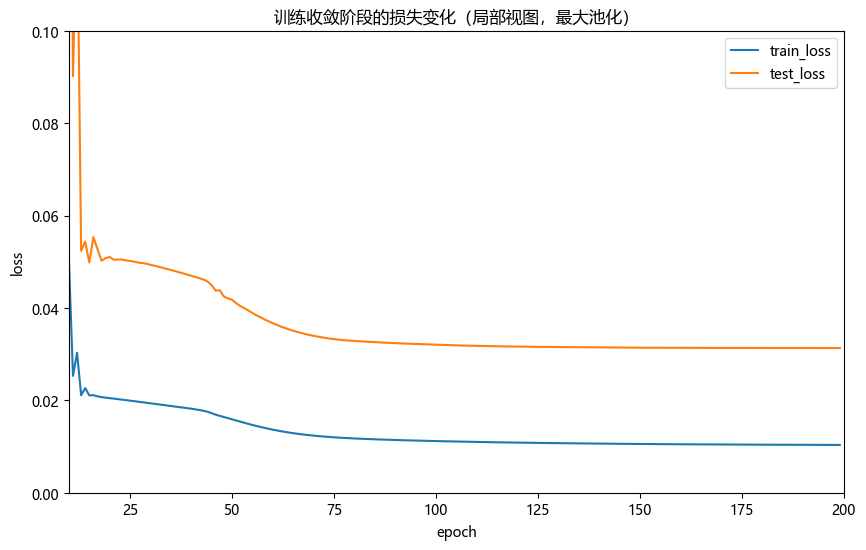

In [17]:
# 绘制局部放大后的loss曲线（平均池化）
# 创建横坐标：从0到num_epochs-1的epoch序列
x = np.arange(num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(x, train_loss, label="train_loss", linewidth=1.5)
plt.plot(x, test_loss, label="test_loss", linewidth=1.5)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

# 设置横轴显示范围：从第10个epoch到最后一个epoch（聚焦收敛阶段）
plt.xlim(10, num_epochs)

# 设置纵轴显示范围：从0到0.1（按实际损失调整）
plt.ylim(0, 0.1)

# 添加标题，说明这是局部视图
plt.title("训练收敛阶段的损失变化（局部视图，平均池化）")
plt.show()

# 绘制局部放大后的loss曲线（最大池化）
# 创建横坐标：从0到num_epochs-1的epoch序列
x = np.arange(num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(x, train_loss_max, label="train_loss", linewidth=1.5)
plt.plot(x, test_loss_max, label="test_loss", linewidth=1.5)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
# 设置横轴显示范围：从第10个epoch到最后一个epoch（聚焦收敛阶段）
plt.xlim(10, num_epochs)

# 设置纵轴显示范围：从0到0.1（按实际损失调整）
plt.ylim(0, 0.1)

# 添加标题，说明这是局部视图
plt.title("训练收敛阶段的损失变化（局部视图，最大池化）")
plt.show()

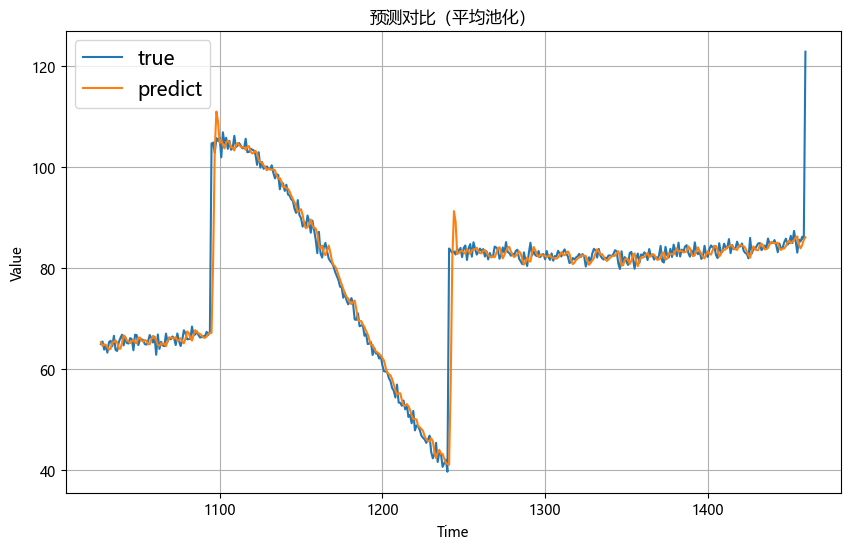

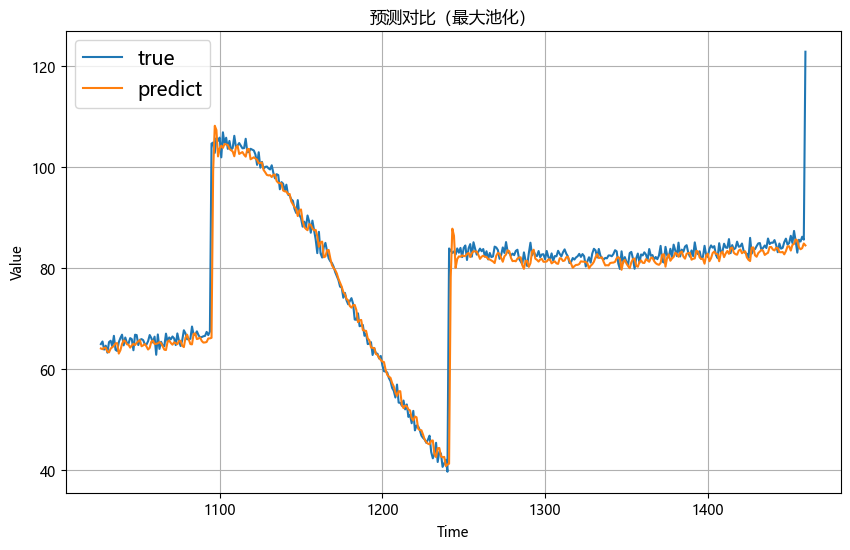

In [18]:
# 预测对比（平均池化）
# 存储测试集的预测结果
test_predict = []

# 计算数据集划分点：按比例 split_prop 划分训练集和测试集
split_point = int(split_prop * int(series.size))

# 测试集的时间轴：从划分点 + 窗口大小后开始（确保每个预测点都有完整历史）
test_time = time[split_point + window_size - 1:]

# 测试集的真实值序列：与 test_time 对应的实际观测值
test_true = series[split_point + window_size - 1:]

# 使用训练好的网络模型对测试特征进行预测
net_avg.eval()
with torch.no_grad():
    test_predict = net_avg(test_feature).detach().cpu().squeeze().tolist()

# 可视化：将真实序列与预测序列绘制在同一图中进行对比
plt.figure(figsize=(10, 6))
plot_series(test_time, test_true, label='true')
plot_series(test_time, test_predict, label='predict')
plt.title("预测对比（平均池化）")
plt.show()

# 预测对比（最大池化）
# 存储测试集的预测结果
test_predict_max = []
# 计算数据集划分点：按比例 split_prop 划分训练集和测试集
split_point = int(split_prop * int(series.size))
# 测试集的时间轴：从划分点 + 窗口大小后开始（确保每个预测点都有完整历史）
test_time = time[split_point + window_size - 1:]
# 测试集的真实值序列：与 test_time 对应的实际观测值
test_true = series[split_point + window_size - 1:]
# 使用训练好的网络模型对测试特征进行预测
net_max.eval()
with torch.no_grad():
    test_predict_max = net_max(test_feature).detach().cpu().squeeze().tolist()
# 可视化：将真实序列与预测序列绘制在同一图中进行对比
plt.figure(figsize=(10, 6))
plot_series(test_time, test_true, label='true')
plot_series(test_time, test_predict_max, label='predict')
plt.title("预测对比（最大池化）")
plt.show()

## 4.真实数据处理

In [19]:
# 读取原始文件，并将日期列设为索引
# na_values="+9999.9", "9", "+9999.9","9999","9"识别为缺失值
data = pd.read_csv("data_exp04_V2.csv", index_col="DATE", na_values="+9999.9, 9")
data = data["TMP"]  # 选取气温（TMP）一列，只保留温度数据

# 将data.index设置为时间索引，便于时间序列操作
data.index = pd.to_datetime(data.index)
# 设置开始与结束时间，选择特定时间段的数据进行分析
start_time = pd.to_datetime("2019-01-01 00:00:00")
end_time = pd.to_datetime("2019-06-30 23:00:00")
data = data[start_time:end_time]  # 切片操作，选取2019年上半年的数据

# 从data中剔除TMP列为NaN的数据，清理缺失值
data = data.dropna()

# 数据格式转换：将TMP数据从字符串转为整数，并获取正确的数值
data = data.str.split(",", expand=True)[0]   # 按逗号分割字符串，取第一部分
data = data.astype("int") / 10               # 转换为整数后除以10，得到实际温度值（可能是华氏度转摄氏度）

# 将时间补齐（期间有丢失的整点数据），并将时间间隔设置为1小时，重新设置data的索引
time = pd.date_range(start=start_time, end=end_time, freq="h")
data = data.reindex(time)  # 重新索引并对齐数据，缺失位置会填充NaN

# 进行线性插值，补全重新索引后仍存在的缺失数据
data = data.interpolate()   # 对缺失的整点的线性插值来填充NaN值

# 处理好的pandas Series数据转换为numpy array类型，与前面实验的数据格式保持一致
series = np.array(data)

C:\Users\Alstar\AppData\Local\Temp\ipykernel_59888\3805885984.py:3: DtypeWarning: Columns (4,6,7,8,9,10,11,12,13,14,17,18,20,21,22,23,25,26,27,28,29,31,32,33,34,35,36,37,39,41,45,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data_exp04_V2.csv", index_col="DATE", na_values="+9999.9, 9")


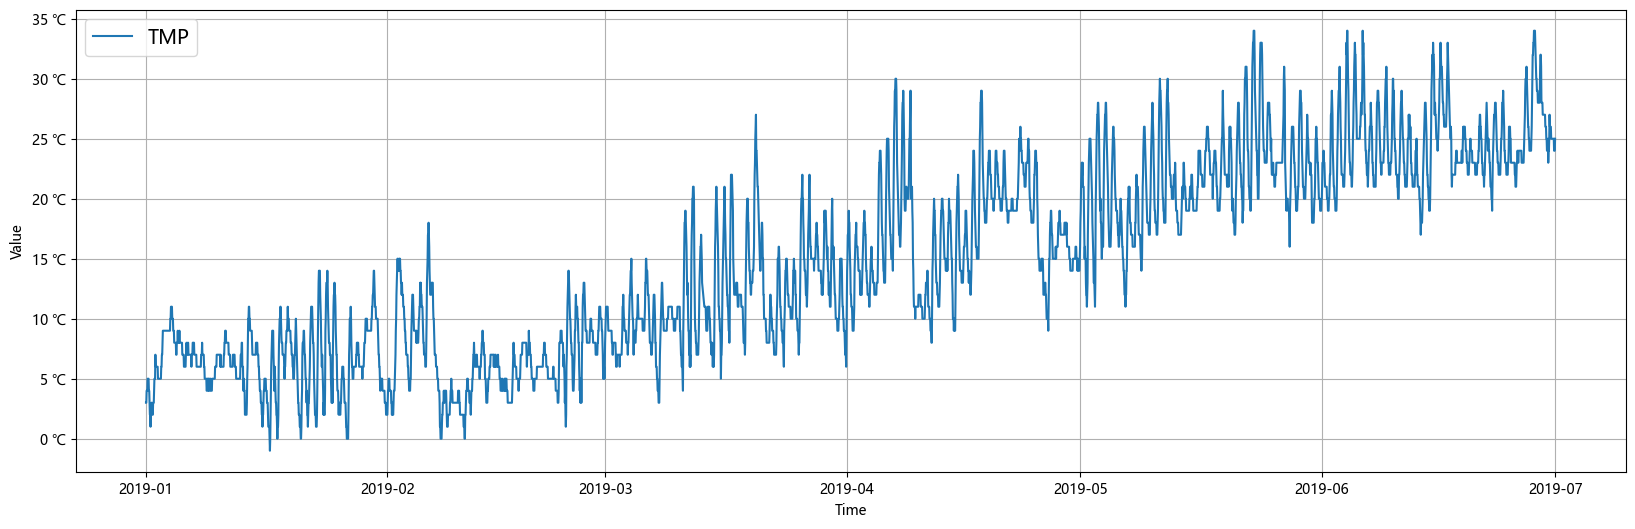

In [20]:
# 导入刻度格式化模块，用于自定义坐标轴显示格式
import matplotlib.ticker as mticker

# 数据可视化
fig, ax = plt.subplots(figsize=(20, 6))
# 设置纵轴单位格式
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d ℃'))
# 自定义Y轴刻度标签格式：
# - mticker.FormatStrFormatter: 使用字符串格式化刻度标签
# - '%d ℃'：格式字符串，%d表示将数值格式化为整数，℃表示温度单位

# 绘制时间序列数据
plot_series(time, series, label='TMP')
plt.show()


In [21]:
# 真实数据处理
split_prop = 0.7
# 按照划分比例将完整序列分割为训练集和测试集
train, test = train_test_split(series, split_prop)
window_size = 13
# 调用data_process函数进行数据预处理
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)
# 分别输出训练集、测试集的feature和label的形状信息
print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

# 将真实数据移动到device并转换为float类型
train_feature = train_feature.to(device).float()
train_label = train_label.to(device).float()
test_feature = test_feature.to(device).float()
test_label = test_label.to(device).float()

print("真实数据已移动到 device:", device)

torch.Size([3028, 1, 12])
torch.Size([3028, 1])
torch.Size([1292, 1, 12])
torch.Size([1292, 1])
真实数据已移动到 device: cuda


## 5.CNN真实数据回归

In [22]:
# 构建一维神经网络（真实数据）
class ConvModuleReal(nn.Module):
    def __init__(self):
        super(ConvModuleReal, self).__init__()
        # 第一层一维卷积模块
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # 第二层一维卷积模块
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        # 全连接层：64 -> 32 -> 1
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, X):
        """
        前向传播：
        X: [batch_size, 1, sequence_length]
        返回: [batch_size, 1]
        """
        out = self.conv1(X)                 # [batch, 32, seq_len]
        out = F.max_pool1d(out, kernel_size=2,padding=1)          # 最大池化，窗口大小2
        out = self.conv2(out)               # [batch, 64, seq_len']
        out = F.max_pool1d(out, 3)          # 再次最大池化
        out = out.squeeze()                # [batch, 64]
        out = self.fc1(out)                 # [batch, 32]
        out = self.fc2(out)                 # [batch, 1]
        return out
    
# 实例化模型，确保后续单元使用时 net 已定义
T_net = ConvModuleReal()

# 将模型移动到GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T_net.to(device)
# 模型参数初始化（真实数据）
for params in T_net.parameters():
    torch.nn.init.normal_(params, mean=0, std=0.01)

# 定义均方误差损失函数
def square_loss(feature, label):
    return(T_net(feature) - label)**2/2

# 训练超参数设置
lr = 0.001
num_epochs = 100
batch_size = 128
loss = square_loss
# 优化器设置（使用 double 参数的 net_avg）
optimizer_T = torch.optim.Adam(T_net.parameters(), lr)

In [23]:
# 训练模型（真实数据）
# 记录每个epoch的训练损失和测试损失
train_loss_T = []  # 用于记录每个epoch的训练损失
test_loss_T = []   # 用于记录每个epoch的测试损失

for epoch in range(num_epochs):  # 外循环：按训练轮数循环
    train_l_T, test_l_T = 0.0, 0.0
    for X, y in data_iter(batch_size, train_feature, train_label):  # # 内循环：按批次训练
        X = X.float()
        y = y.float()
        l = loss(X, y).sum()
        optimizer_T.zero_grad()
        l.backward()
        optimizer_T.step()
    
    # 当前epoch训练结束后，计算在整个训练集和测试集上的损失
    with torch.no_grad():
        train_feature_float = train_feature.float()
        train_label_float = train_label.float()
        test_feature_float = test_feature.float()
        test_label_float = test_label.float()
        
        # 计算训练集和测试集上的损失
        train_l_T = loss(train_feature_float, train_label_float)
        test_l_T = loss(test_feature_float, test_label_float)
    
    # 记录损失值到列表
    train_loss_T.append(train_l_T.mean().item())  # 记录训练损失的平均值
    test_loss_T.append(test_l_T.mean().item())    # 记录测试损失的平均值
    
    # 输出当前epoch的训练进度
    print('epoch %d, train loss %f, test loss %f' % (epoch + 1, train_l_T.mean().item(), test_l_T.mean().item()))

epoch 1, train loss 62.405750, test loss 229.144104
epoch 2, train loss 5.444983, test loss 6.358898
epoch 3, train loss 5.418124, test loss 5.992391
epoch 4, train loss 4.937331, test loss 5.885554
epoch 5, train loss 4.624096, test loss 5.829548
epoch 6, train loss 4.268113, test loss 5.581621
epoch 7, train loss 3.856769, test loss 5.148849
epoch 8, train loss 3.406029, test loss 4.496881
epoch 9, train loss 2.943713, test loss 3.797784
epoch 10, train loss 2.490386, test loss 3.142556
epoch 11, train loss 2.057087, test loss 2.554957
epoch 12, train loss 1.661607, test loss 1.970049
epoch 13, train loss 1.334581, test loss 1.498302
epoch 14, train loss 1.100158, test loss 1.274165
epoch 15, train loss 0.980132, test loss 1.358107
epoch 16, train loss 0.913404, test loss 1.292760
epoch 17, train loss 0.869270, test loss 1.162252
epoch 18, train loss 0.848684, test loss 1.130347
epoch 19, train loss 0.830750, test loss 1.089242
epoch 20, train loss 0.814358, test loss 1.050890
epoch 

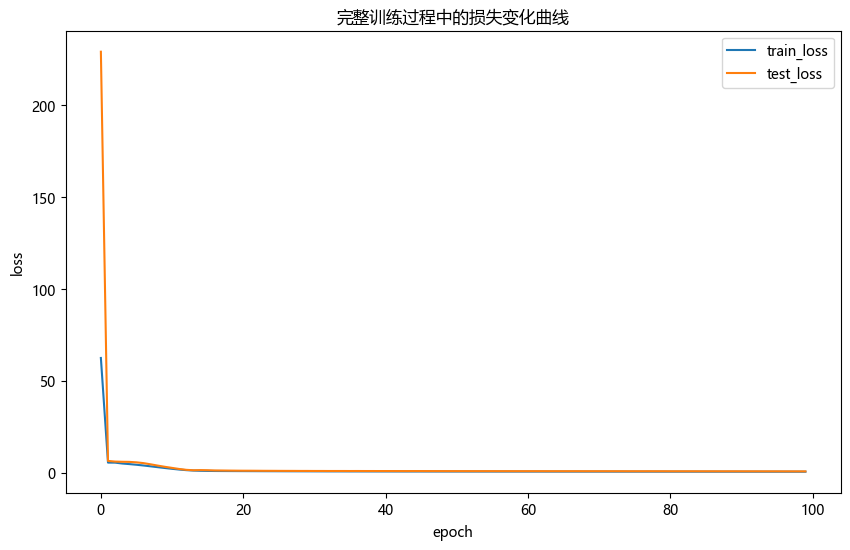

In [24]:
# 绘制完整的loss曲线
# 创建横坐标：从0到num_epochs-1的epoch序列
x = np.arange(num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(x, train_loss_T, label="train_loss", linewidth=1.5)
plt.plot(x, test_loss_T, label="test_loss", linewidth=1.5)

# 设置坐标轴标签
plt.xlabel("epoch")    # 横轴标签：训练轮数
plt.ylabel("loss")     # 纵轴标签：损失值

plt.legend()
plt.title("完整训练过程中的损失变化曲线")
plt.show()

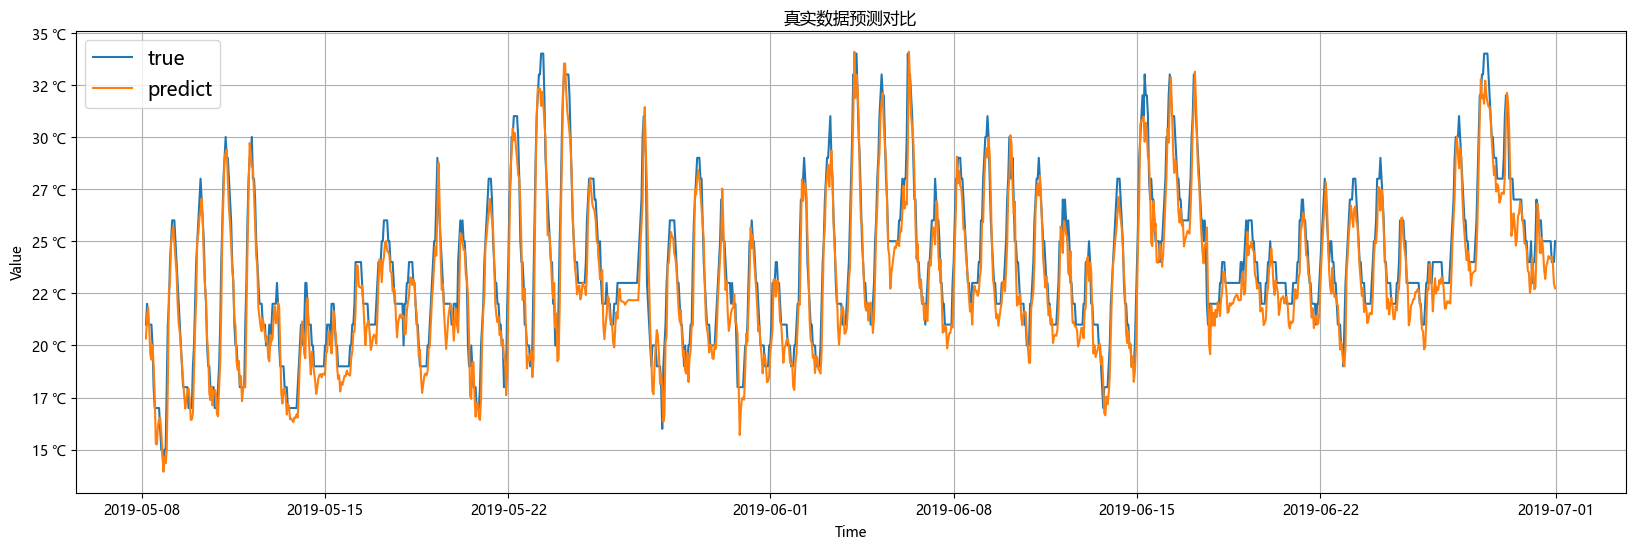

In [25]:
# 预测对比（真实数据）
# 存储测试集的预测结果
test_predict_T = []
# 计算数据集划分点：按比例 split_prop 划分训练集和测试集
split_point = int(split_prop * int(series.size))
test_time = time[split_point + window_size - 1:]
test_true = series[split_point + window_size - 1:]
test_predict = T_net(test_feature).squeeze().tolist()

# 可视化：将真实序列与预测序列绘制在同一图中进行对比
fig, ax = plt.subplots(figsize=(20, 6))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d ℃'))
plot_series(test_time, test_true, label='true')
plot_series(test_time, test_predict, label='predict')
plt.title("真实数据预测对比")
plt.show()

## 6.CNN真实数据回归 自建网络

In [26]:
# 构建优化的卷积神经网络（自建网络）
class ConvModuleCustom(nn.Module):
    def __init__(self):
        super(ConvModuleCustom, self).__init__()
        
        # 第一层一维卷积模块：1 -> 32
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU(inplace=True)
        
        # 第二层一维卷积模块：32 -> 64
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # 第三层一维卷积模块（新增）：64 -> 128
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # 全连接层：128 -> 64 -> 32 -> 1
        self.fc1 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, X):
        """
        前向传播：
        X: [batch_size, 1, sequence_length]
        返回: [batch_size, 1]
        """
        # 第一层卷积块
        out = self.conv1(X)                 # [batch, 32, seq_len]
        out = self.bn1(out)
        out = self.relu1(out)
        out = F.max_pool1d(out, kernel_size=2, padding=1)  # 最大池化，窗口大小2
        
        # 第二层卷积块
        out = self.conv2(out)               # [batch, 64, seq_len']
        out = self.bn2(out)
        out = self.relu2(out)
        out = F.max_pool1d(out, 2)          # 再次最大池化
        
        # 第三层卷积块（新增）
        out = self.conv3(out)               # [batch, 128, seq_len'']
        out = self.bn3(out)
        out = self.relu3(out)
        out = F.max_pool1d(out, 2)          # 第三次最大池化
        
        # 展平处理
        out = out.squeeze()                # [batch, 128]
        
        # 全连接层
        out = self.fc1(out)                 # [batch, 64]
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)                 # [batch, 32]
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out = self.fc3(out)                 # [batch, 1]
        
        return out

# 实例化模型
custom_net = ConvModuleCustom()
custom_net = custom_net.to(device)
custom_net = custom_net.float()

# 参数初始化
for params in custom_net.parameters():
    torch.nn.init.normal_(params, mean=0, std=0.01)

# 定义损失函数
def custom_loss(feature, label):
    return (custom_net(feature) - label) ** 2 / 2

# 超参数设置
lr_custom = 0.001
num_epochs_custom = 100
batch_size_custom = 128
loss_custom = custom_loss

# 优化器和学习率调度
optimizer_custom = torch.optim.Adam(custom_net.parameters(), lr=lr_custom)

In [27]:
# 训练自建网络模型
train_loss_custom = []
test_loss_custom = []
best_test_loss = float('inf')

for epoch in range(num_epochs_custom):
    # 训练阶段
    custom_net.train()
    train_l_custom = 0.0
    num_batches = 0
    
    for X, y in data_iter(batch_size_custom, train_feature, train_label):
        X = X.float()
        y = y.float()
        
        # 前向传播
        output = custom_net(X)
        l = torch.mean((output - y) ** 2)
        
        # 反向传播
        optimizer_custom.zero_grad()
        l.backward()
        torch.nn.utils.clip_grad_norm_(custom_net.parameters(), max_norm=1.0)
        optimizer_custom.step()
        
        train_l_custom += l.item()
        num_batches += 1
    
    train_l_custom /= num_batches
    
    # 评估阶段
    custom_net.eval()
    with torch.no_grad():
        train_output = custom_net(train_feature.float())
        test_output = custom_net(test_feature.float())
        
        train_loss_epoch = torch.mean((train_output - train_label.float()) ** 2).item()
        test_loss_epoch = torch.mean((test_output - test_label.float()) ** 2).item()
    
    train_loss_custom.append(train_loss_epoch)
    test_loss_custom.append(test_loss_epoch)
    
    print('epoch %d, train loss %.6f, test loss %.6f' % (epoch + 1, train_loss_epoch, test_loss_epoch))

epoch 1, train loss 156.625977, test loss 576.751648
epoch 2, train loss 143.397415, test loss 545.473938
epoch 3, train loss 68.836540, test loss 292.294464
epoch 4, train loss 1.517433, test loss 0.766723
epoch 5, train loss 26.620558, test loss 89.080170
epoch 6, train loss 2.268141, test loss 5.706886
epoch 7, train loss 1.817394, test loss 4.315100
epoch 8, train loss 1.804911, test loss 2.869294
epoch 9, train loss 1.889691, test loss 2.531262
epoch 10, train loss 0.751878, test loss 1.495314
epoch 11, train loss 0.690781, test loss 0.873521
epoch 12, train loss 1.433208, test loss 2.512848
epoch 13, train loss 0.795186, test loss 0.688078
epoch 14, train loss 1.518163, test loss 4.093452
epoch 15, train loss 0.897011, test loss 1.409413
epoch 16, train loss 0.747093, test loss 1.257350
epoch 17, train loss 0.966515, test loss 1.499356
epoch 18, train loss 1.438216, test loss 5.103312
epoch 19, train loss 0.928010, test loss 1.456915
epoch 20, train loss 0.764444, test loss 0.841

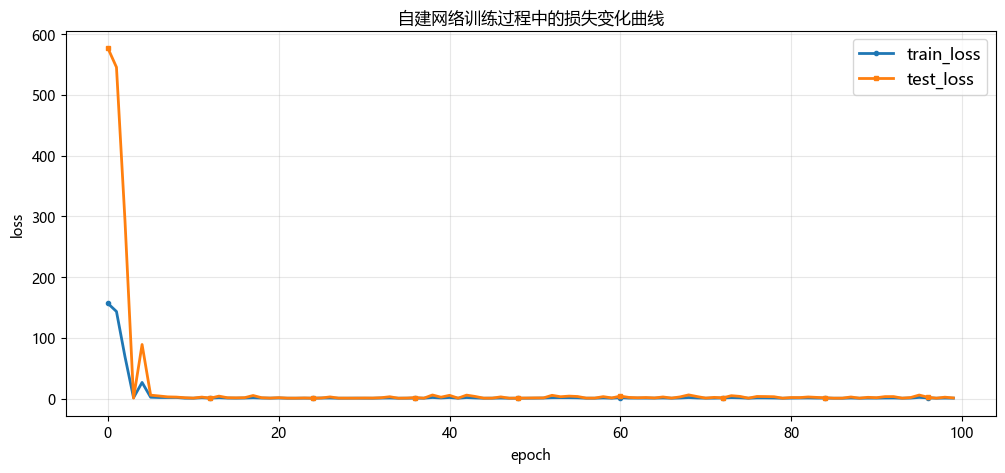

In [28]:
# 绘制自建网络的loss曲线
x = np.arange(num_epochs_custom)

# 完整loss曲线
plt.figure(figsize=(12, 5))
plt.plot(x, train_loss_custom, label="train_loss", linewidth=2, marker='o', markersize=3, markevery=12)
plt.plot(x, test_loss_custom, label="test_loss", linewidth=2, marker='s', markersize=3, markevery=12)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(fontsize=12)
plt.title("自建网络训练过程中的损失变化曲线")
plt.grid(True, alpha=0.3)
plt.show()

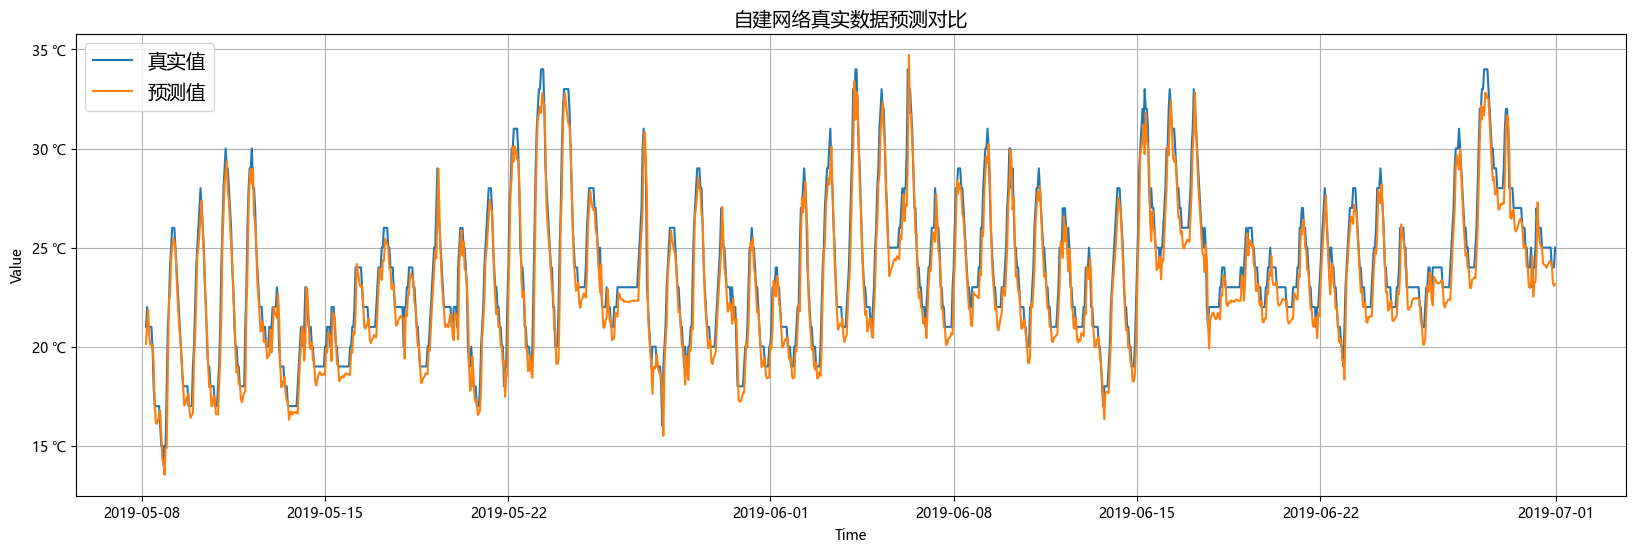

In [29]:
# 自建网络预测对比
custom_net.eval()
split_point = int(split_prop * int(series.size))
test_time = time[split_point + window_size - 1:]
test_true = series[split_point + window_size - 1:]

with torch.no_grad():
    test_predict_custom = custom_net(test_feature.float()).squeeze().detach().cpu().numpy()

# 可视化预测结果
fig, ax = plt.subplots(figsize=(20, 6))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d ℃'))
plot_series(test_time, test_true, label='真实值')
plot_series(test_time, test_predict_custom, label='预测值')
plt.title("自建网络真实数据预测对比", fontsize=14)
plt.show()

CNN模型性能指标对比
          指标    原始CNN    自建CNN  改进幅度 (%)
  均方误差 (MSE) 1.331992 1.118099     16.06
均方根误差 (RMSE) 1.154120 1.057402      8.38
平均绝对误差 (MAE) 0.925060 0.850714      8.04
   决定系数 (R²) 0.899750 0.915848     -1.79
 相关系数 (Corr) 0.967208 0.975158     -0.82


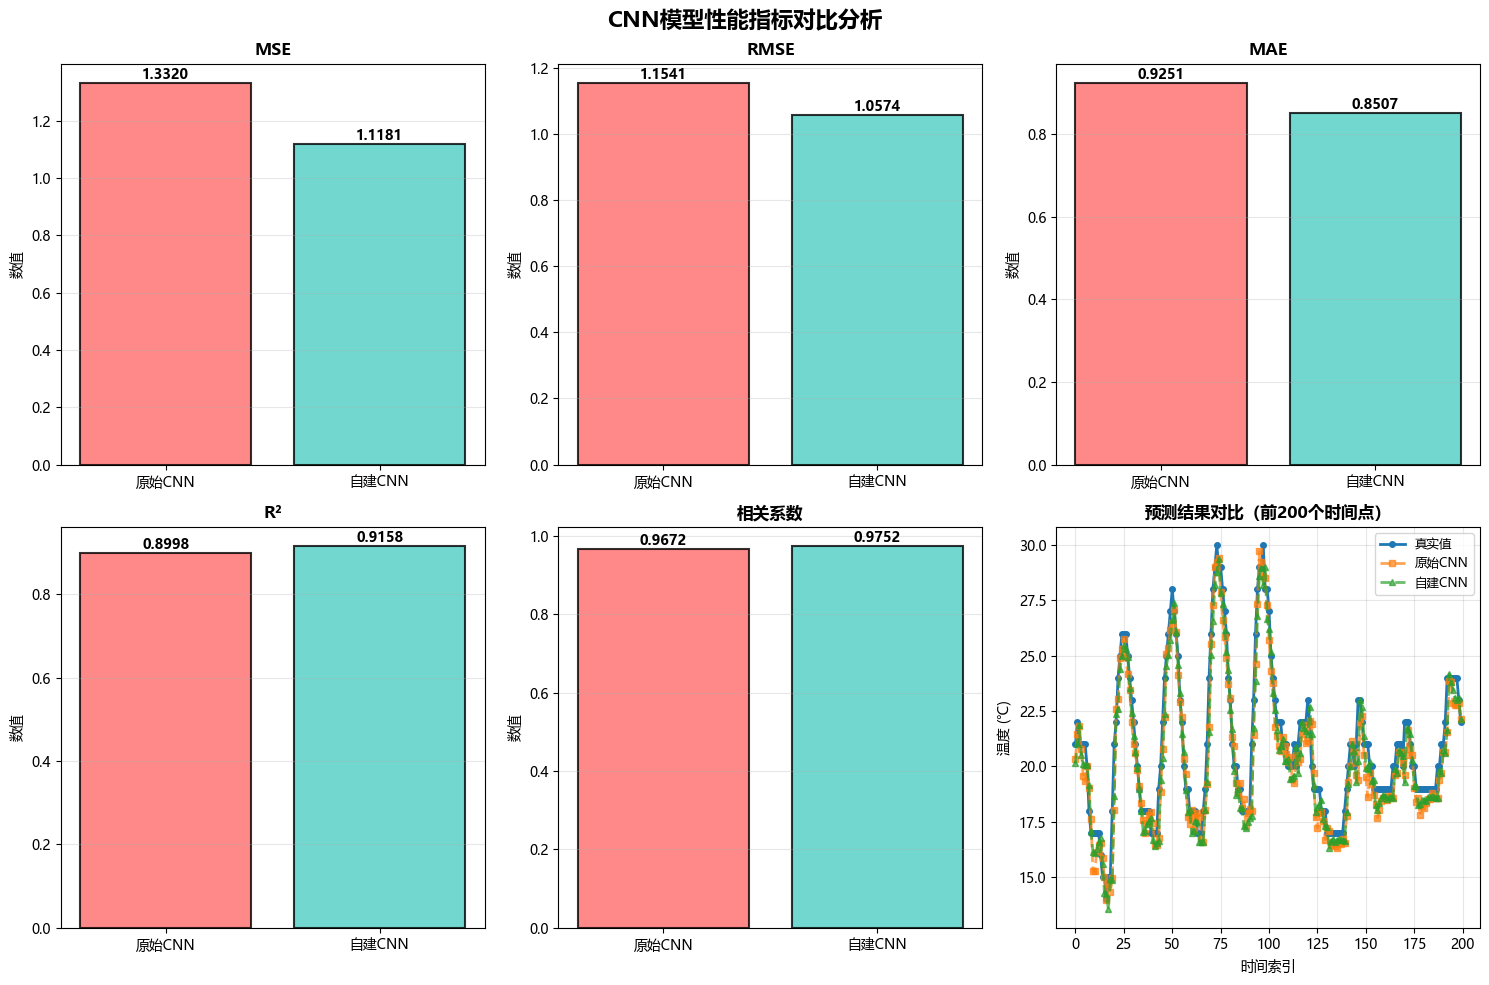


性能总结报告
✓ 自建CNN在R²指标上优于原始CNN，提升幅度: 1.79%
✓ 自建CNN平均绝对误差更低，降低幅度: 8.04%
✓ 自建CNN均方根误差更低，降低幅度: 8.38%


In [30]:
# 计算自建CNN与原始CNN的性能指标对比
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 获取测试集真实值
test_true_array = np.array(test_true)

# === 原始CNN模型预测 ===
T_net.eval()
with torch.no_grad():
    test_pred_original = T_net(test_feature.float()).squeeze().detach().cpu().numpy()

# === 自建CNN模型预测 ===
custom_net.eval()
with torch.no_grad():
    test_pred_custom = custom_net(test_feature.float()).squeeze().detach().cpu().numpy()

# === 计算原始CNN的性能指标 ===
mse_original = mean_squared_error(test_true_array, test_pred_original)
mae_original = mean_absolute_error(test_true_array, test_pred_original)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(test_true_array, test_pred_original)
corr_original = np.corrcoef(test_true_array, test_pred_original)[0, 1]

# === 计算自建CNN的性能指标 ===
mse_custom = mean_squared_error(test_true_array, test_pred_custom)
mae_custom = mean_absolute_error(test_true_array, test_pred_custom)
rmse_custom = np.sqrt(mse_custom)
r2_custom = r2_score(test_true_array, test_pred_custom)
corr_custom = np.corrcoef(test_true_array, test_pred_custom)[0, 1]

# === 创建性能指标对比表格 ===
metrics_comparison = pd.DataFrame({
    '指标': ['均方误差 (MSE)', '均方根误差 (RMSE)', '平均绝对误差 (MAE)', '决定系数 (R²)', '相关系数 (Corr)'],
    '原始CNN': [mse_original, rmse_original, mae_original, r2_original, corr_original],
    '自建CNN': [mse_custom, rmse_custom, mae_custom, r2_custom, corr_custom]
})

# 计算改进幅度（百分比）
metrics_comparison['改进幅度 (%)'] = ((metrics_comparison['原始CNN'] - metrics_comparison['自建CNN']) / 
                                       metrics_comparison['原始CNN'] * 100).round(2)

print("="*80)
print("CNN模型性能指标对比")
print("="*80)
print(metrics_comparison.to_string(index=False))
print("="*80)

# === 绘制性能指标对比柱状图 ===
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('CNN模型性能指标对比分析', fontsize=16, fontweight='bold')

# 指标名称和对应数据
metrics_names = ['MSE', 'RMSE', 'MAE', 'R²', '相关系数']
original_values = [mse_original, rmse_original, mae_original, r2_original, corr_original]
custom_values = [mse_custom, rmse_custom, mae_custom, r2_custom, corr_custom]

# 前5个子图：逐个指标对比
for idx, (name, orig, cust) in enumerate(zip(metrics_names, original_values, custom_values)):
    ax = axes[idx // 3, idx % 3]
    models = ['原始CNN', '自建CNN']
    values = [orig, cust]
    bars = ax.bar(models, values, color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # 在柱子上添加数值标签
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_ylabel('数值', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

# 第6个子图：预测结果可视化对比
ax = axes[1, 2]
time_indices = np.arange(len(test_true_array[:200]))  # 显示前200个时间点
ax.plot(time_indices, test_true_array[:200], 'o-', label='真实值', linewidth=2, markersize=4)
ax.plot(time_indices, test_pred_original[:200], 's--', label='原始CNN', linewidth=2, markersize=4, alpha=0.7)
ax.plot(time_indices, test_pred_custom[:200], '^--', label='自建CNN', linewidth=2, markersize=4, alpha=0.7)
ax.set_xlabel('时间索引', fontsize=10)
ax.set_ylabel('温度 (℃)', fontsize=10)
ax.set_title('预测结果对比（前200个时间点）', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# === 生成性能总结报告 ===
print("\n" + "="*80)
print("性能总结报告")
print("="*80)
if r2_custom > r2_original:
    print(f"✓ 自建CNN在R²指标上优于原始CNN，提升幅度: {((r2_custom - r2_original)/abs(r2_original)*100):.2f}%")
else:
    print(f"✗ 自建CNN在R²指标上略逊于原始CNN")

if mae_custom < mae_original:
    print(f"✓ 自建CNN平均绝对误差更低，降低幅度: {((mae_original - mae_custom)/mae_original*100):.2f}%")
else:
    print(f"✗ 自建CNN平均绝对误差较高")

if rmse_custom < rmse_original:
    print(f"✓ 自建CNN均方根误差更低，降低幅度: {((rmse_original - rmse_custom)/rmse_original*100):.2f}%")
else:
    print(f"✗ 自建CNN均方根误差较高")

print("="*80)